<a href="https://colab.research.google.com/github/Kanakanajm/nnti/blob/main/NNTIProject/notebooks/task1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1: Language model inference

The goal if this first task is to familiarize yourself with the huggingface transformers and dataset libraries. You will learn how to load and tokenize a dataset, how to load a pre-trained language model, and finally, how to run a model in inference mode.

Your task is to complete the missing code blocks below.

In [1]:
# Uncomment this if you're viewing this on Google Colab

# download the requirements.txt hosted on a Github public gist
# !wget https://gist.githubusercontent.com/CamiloMartinezM/7eb6f86e2642e24776c90433c29133de/raw/8e7d8ab19bc8f55fe2e837c1d1d0fe3026519fb1/requirements.txt -O requirements.txt
# install the required libraries
# !pip install -r requirements.txt

In [2]:
# import dependencies
from typing import Callable, Any
from functools import partial
from gc import collect as garbage_collect
from torch.cuda import empty_cache as cuda_empty_cache, mem_get_info
import matplotlib.pyplot as plt
import matplotlib
import warnings
import numpy as np
import torch
import json
import os

from datasets import (
    load_dataset,
    load_dataset_builder,
    get_dataset_split_names,
    get_dataset_config_names,
)
from transformers import (
    XGLMTokenizer,
    XGLMTokenizerFast,
    XGLMForCausalLM,
    AutoModelForCausalLM,
    AutoTokenizer,
    GenerationConfig,
)

# added constants that will be used throughout the notebook
USE_SPLITS = ["dev", "devtest"]  # Set up the splits to download
IGNORE_PADDING_TOKEN_INT = -100  # Ignore padding token explicitly. If it is None, then no explicit ignoring is done.
BATCH_SIZE = 2  # for testing purposes, we start with a batch size of 2. You can change this later.
SPLIT_TO_PLOT = "devtest"  # Set up the split to plot at the end
TORCH_DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")  # device to run the model on
CACHE_DIR = "/run/media/Camilo/Personal/cache/" # Change this to the folder you want the cached model, tokenizers, etc.
LOCAL_CACHE = "../cache/"  # For plots and other local files that are not as big

# set up figure parameters to make them look nice
plt.rcParams["axes.formatter.use_mathtext"] = True
matplotlib.rcParams["font.family"] = "cmr10"
matplotlib.rcParams["axes.unicode_minus"] = False
matplotlib.rcParams.update({"font.size": 11})

# other utils functions
from copy import deepcopy
from pprint import pprint, pformat


def left_indent(text, indent: str = "\t"):
    return "".join([indent + l for l in text.splitlines(True)])


def pprint_tab(obj, indent: str = "\t"):
    print(left_indent(pformat(obj), indent))


def get_available_objects(data):
    return [obj for obj in dir(data) if not obj.startswith("__")]


def copy(obj):
    return deepcopy(obj)


def save_tensor_to(dst: str, filename: str, t: torch.Tensor, overwrite: bool = True) -> None:
    if not os.path.exists(dst):
        os.makedirs(dst)
    fullpath = os.path.join(dst, filename)
    # save to file if it does not exist or if it does exist and overwrite = True
    if (os.path.exists(fullpath) and overwrite) or not os.path.exists(fullpath):
        torch.save(t, fullpath)


def join_list_elements_with_char(elements: list, join_char: str = "_") -> str:
    """Joins the string representations of elements in a list with a specified character."""
    if len(elements) == 0:
        return ""

    # Convert all elements to strings in case they are not
    str_elements = [str(element) for element in elements]
    # Join the string elements with the specified character
    return join_char.join(str_elements)


def save_json_to(dst: str, filename: str, json_var: dict, overwrite: bool = True) -> None:
    """Save data to a specified file in JSON format."""
    if not os.path.exists(dst):
        os.makedirs(dst)

    # Check if the file already exists
    filename_fullpath = os.path.join(dst, filename)
    if os.path.exists(filename_fullpath) and not overwrite:
        warnings.warn(f"The file {filename_fullpath} already exists and it won't be overwritten.")
        return

    with open(filename_fullpath, "w") as f:
        json.dump(json_var, f, sort_keys=True, indent=4)


def load_json_from(src: str, filename: str, trigger_exception: bool = False, trigger_warning: bool = True) -> dict:
    """Load JSON data from a specified file to a dictionary."""
    filename_fullpath = os.path.join(src, filename)
    if os.path.exists(filename_fullpath):
        with open(filename_fullpath, "r") as f:
            json_var = json.load(f)
        return json_var
    else:
        if trigger_warning:
            warnings.warn(f"{filename_fullpath} does not exist, returning None instead")
        elif trigger_exception:
            raise Exception(f"{filename_fullpath} does not exist")
        return None


def make_str_safe_for_dirs(
    input_str: str, chars_to_replace: list = ["/", "\\", ":", "*", "?", '"', "<", ">", "|"], replacement_char=""
):
    """Sanitizes a string by replacing specified characters with a replacement character."""
    # Replace each specified character with the replacement character
    for char in chars_to_replace:
        input_str = input_str.replace(char, replacement_char)

    return input_str


def load_or_generate_data(directory: str, filename: str, generation_func: Callable, *args, **kwargs) -> Any:
    """Attempt to load data from a JSON file. If the file does not exist, the data is generated using a specified
    function, saved to the file, and then returned.

    This function is useful for situations where you want to cache data that takes a long time to compute by saving it
    to a file and loading it directly if it already exists. If the JSON file cannot be found, the generation_func is
    called with the provided args and kwargs, the result is saved to a JSON file, and then returned.

    Parameters
    ----------
    directory : str
        Directory where the file is located or will be saved.
    filename : str
        Name of the file to load or save the data.
    generation_func : Callable
        Function to generate the data if the file does not exist. It should return the data to be saved.
    *args
        Positional arguments to pass to the generation function.
    **kwargs
        Keyword arguments to pass to the generation function.

    Returns
    -------
    Any
        The loaded or generated data.
    """
    data = load_json_from(directory, filename, trigger_warning=False)
    if data is None:
        print(f"File {filename} not found. Generating data...")
        data = generation_func(*args, **kwargs)
        save_json_to(directory, filename, data)
    else:
        print(f"Data loaded from {filename}.")
    return data

# helper funcs
def clean():
    # release memory
    garbage_collect()
    cuda_empty_cache()

    mem_info = mem_get_info()
    print(f"Freeing GPU Memory\nFree: %d MB\tTotal: %d MB" % (mem_info[0] // 1024**2, mem_info[1] // 1024**2))

## Explore dataset

In [3]:
DATA_SET_NAME = "facebook/flores"  # specify dataset name
MODEL_NAME = "facebook/xglm-564M"  # specify model name
# MODEL_NAME = "gpt2" # specify model name

In [4]:
# Explore a dataset
LANGUAGE_CODE = "deu_Latn"  # Language to explore

# covered language codes can be found here: https://github.com/openlanguagedata/flores?tab=readme-ov-file#language-coverage

ds_builder = load_dataset_builder(DATA_SET_NAME, LANGUAGE_CODE, trust_remote_code=True)
print(ds_builder.info.description)  # print the dataset description

The creation of FLORES-200 doubles the existing language coverage of FLORES-101. 
Given the nature of the new languages, which have less standardization and require 
more specialized professional translations, the verification process became more complex. 
This required modifications to the translation workflow. FLORES-200 has several languages 
which were not translated from English. Specifically, several languages were translated 
from Spanish, French, Russian and Modern Standard Arabic. Moreover, FLORES-200 also 
includes two script alternatives for four languages. FLORES-200 consists of translations 
from 842 distinct web articles, totaling 3001 sentences. These sentences are divided 
into three splits: dev, devtest, and test (hidden). On average, sentences are approximately 
21 words long.



In [5]:
# print the features (columns) of the dataset
pprint(ds_builder.info.features)

{'URL': Value(dtype='string', id=None),
 'domain': Value(dtype='string', id=None),
 'has_hyperlink': Value(dtype='int32', id=None),
 'has_image': Value(dtype='int32', id=None),
 'id': Value(dtype='int32', id=None),
 'sentence': Value(dtype='string', id=None),
 'topic': Value(dtype='string', id=None)}


In [6]:
# get the available splits
pprint(ds_builder.info.splits)

None


## Load data, tokenize, and batchify

In [7]:
# specify languages
LANGUAGES = ["eng_Latn", "spa_Latn", "ita_Latn", "deu_Latn", "arb_Arab", "tel_Telu", "tam_Taml", "quy_Latn", "zho_Hans"]

In [8]:
def load_flores_dataset_per_language(languages: list, subset: int = -1, verbose: bool = True) -> dict:
    """Load flores+ dataset for each language. The structure of the returned dictionary is as follows:

    ```
    dataset_per_lang = {
        language: {
            "dataset": {
                split (dev/devtest): {
                    "raw": raw dataset (without tokenization),
                    "tokenized": tokenized dataset
                }
            },
            "dataloader": {
                split (dev/devtest): dataloader for the split
            }
        }
    }
    ```
    Parameters
    ----------
    languages : list
        List of languages to load.
    subset : int
        Number of examples to load for each language. If -1, all examples are loaded.
    verbose : bool, optional
        Whether to print information about the loading process, by default True

    Returns
    -------
    dict
        A dictionary with the dataset and dataloader for each language and split.
    """
    dataset = {}
    for language in languages:
        if verbose:
            print(f"Loading dataset for {language}", end="... ")

        dataset[language] = {"dataset": {}}
        for split in USE_SPLITS:
            dataset[language]["dataset"][split] = {}
            dataset[language]["dataset"][split]["raw"] = load_dataset(
                DATA_SET_NAME,
                language,
                split=split,
                trust_remote_code=True,
                cache_dir=os.path.join(CACHE_DIR, "languages"),
            )

        if verbose:
            print("done")

    # Subset the dataset if subset != -1
    if subset > 0:
        if verbose:
            print(f"Subsetting dataset to {subset} examples per language... ", end="")

        for language in languages:
            for split in USE_SPLITS:
                dataset[language]["dataset"][split]["raw"] = dataset[language]["dataset"][split]["raw"].select(
                    list(range(subset))
                )

        if verbose:
            print("Done")

    return dataset


orig_dataset_per_lang = load_flores_dataset_per_language(LANGUAGES)

Loading dataset for eng_Latn... done
Loading dataset for spa_Latn... done
Loading dataset for ita_Latn... done
Loading dataset for deu_Latn... done
Loading dataset for arb_Arab... done
Loading dataset for tel_Telu... done
Loading dataset for tam_Taml... done
Loading dataset for quy_Latn... done
Loading dataset for zho_Hans... done


In [9]:
# let's look at the English subset
EX_DATASET_LANG = "eng_Latn"
english_dataset = orig_dataset_per_lang[EX_DATASET_LANG]["dataset"]["dev"]["raw"]
print(f"Size of the english dataset: {english_dataset.info.dataset_size}")
print("Features:")
pprint_tab(english_dataset.info.features)
print("\nSplits:")
pprint_tab(english_dataset.info.splits)

Size of the english dataset: 501481
Features:
	{'URL': Value(dtype='string', id=None),
	 'domain': Value(dtype='string', id=None),
	 'has_hyperlink': Value(dtype='int32', id=None),
	 'has_image': Value(dtype='int32', id=None),
	 'id': Value(dtype='int32', id=None),
	 'sentence': Value(dtype='string', id=None),
	 'topic': Value(dtype='string', id=None)}

Splits:
	{'dev': SplitInfo(name='dev',
	                  num_bytes=245488,
	                  num_examples=997,
	                  shard_lengths=None,
	                  dataset_name='flores'),
	 'devtest': SplitInfo(name='devtest',
	                      num_bytes=255993,
	                      num_examples=1012,
	                      shard_lengths=None,
	                      dataset_name='flores')}


In [10]:
# let's look at an individual sample from the dataset
def get_sample(idx: int, lang: str, split: str, data: str, dataset: dict):
    return dataset[lang]["dataset"][split][data][idx]


print(f"Viewing raw samples from {EX_DATASET_LANG}:")
for split in USE_SPLITS:
    first_sample = get_sample(0, EX_DATASET_LANG, split, "raw", orig_dataset_per_lang)
    last_sample = get_sample(-1, EX_DATASET_LANG, split, "raw", orig_dataset_per_lang)
    dataset_len = len(orig_dataset_per_lang[EX_DATASET_LANG]["dataset"][split]["raw"]) - 1

    print("")
    print(f"\tFirst sample from {split} split:")
    pprint_tab(first_sample, indent="\t\t")
    print("")
    print(f"\t{dataset_len}-th sample from {split} split:")
    pprint_tab(last_sample, indent="\t\t")

Viewing raw samples from eng_Latn:

	First sample from dev split:
		{'URL': 'https://en.wikinews.org/wiki/Scientists_say_new_medical_diagnostic_chip_can_sort_cells_anywhere_with_an_inkjet',
		 'domain': 'wikinews',
		 'has_hyperlink': 0,
		 'has_image': 0,
		 'id': 1,
		 'sentence': 'On Monday, scientists from the Stanford University School of '
		             'Medicine announced the invention of a new diagnostic tool that '
		             'can sort cells by type: a tiny printable chip that can be '
		             'manufactured using standard inkjet printers for possibly about '
		             'one U.S. cent each.',
		 'topic': 'health'}

	996-th sample from dev split:
		{'URL': 'https://en.wikivoyage.org/wiki/Funeral_travel',
		 'domain': 'wikivoyage',
		 'has_hyperlink': 0,
		 'has_image': 0,
		 'id': 997,
		 'sentence': 'In all cases, you must book by phone directly with the airline.',
		 'topic': 'Reason to travel/Funeral travel'}

	First sample from devtest split:
		{'URL': 'https

In [11]:
# tokenize the data
def apply_tokenizer(tokenizer: XGLMTokenizerFast, example: dict, padding: str = None):
    """Specify the tokenization function. If padding is specified, then it is used inside the tokenizer function."""
    return tokenizer(
        example["sentence"],
        padding=padding if padding else False,
        truncation=True if padding else False,
        return_tensors="pt",
    )


def tokenize_dataset(dataset: dict, model_name: str) -> dict:
    """Tokenize the dataset using a loaded pre-trained tokenizer from huggingface that goes with the specified model."""
    tokenizer = AutoTokenizer.from_pretrained(model_name, cache_dir="../cache/tokenizers")

    # gpt2 does not have a padding token, so we have to add it manually
    if model_name == "gpt2":
        tokenizer.add_special_tokens({"pad_token": tokenizer.unk_token})

    new_dataset = copy(dataset)
    for language in dataset:
        for split in dataset[language]["dataset"]:
            new_dataset[language]["dataset"][split]["tokenized"] = None

    return new_dataset, tokenizer


dataset_per_lang, tokenizer = tokenize_dataset(orig_dataset_per_lang, MODEL_NAME)

In [12]:
# construct a pytorch data loader for each dataset
def per_batch_padding_collate_fn(batch: list, tokenizer: XGLMTokenizerFast, padding: str = "longest"):
    """Dynamically pad to the longest sequence in the batch."""
    sentences = [item["sentence"] for item in batch]
    batch_padded = tokenizer(
        sentences,
        padding=padding,
        truncation=True,
        return_tensors="pt",
    )
    return batch_padded


def batchify_dataset(
    unbatched_dataset: dict, tokenizer: XGLMTokenizerFast, batch_size: int, verbose: bool = True
) -> dict:
    """Batchify the tokenized dataset using the specified tokenizer."""
    # Create a partially applied version of the collate function that includes the tokenizer. If not defined like this,
    # we get different results if the tokenizer is defined as a global variable instead of given by parameter.
    collate_fn_with_tokenizer = partial(per_batch_padding_collate_fn, tokenizer=tokenizer, padding="longest")

    batched_dataset = copy(unbatched_dataset)
    for language in unbatched_dataset:
        batched_dataset[language]["dataloader"] = {}
        if verbose:
            print(f"Creating dataloaders for {language} (", end="")
        for i, split in enumerate(unbatched_dataset[language]["dataset"]):
            curr_dataset = unbatched_dataset[language]["dataset"][split]["raw"]

            # Set the BATCH_SIZE equal to the length of the dataset, if BATCH_SIZE == -1
            if batch_size == -1:
                batch_size = len(curr_dataset)

            batched_dataset[language]["dataloader"][split] = torch.utils.data.DataLoader(
                curr_dataset,
                batch_size=batch_size,
                collate_fn=collate_fn_with_tokenizer,
                shuffle=False,
            )

            if verbose:
                print(f"{split}: {len(batched_dataset[language]['dataloader'][split])}", end="")

            if verbose and i < len(batched_dataset[language]["dataset"]) - 1:
                print(", ", end="")

            if batch_size == len(curr_dataset):
                batch_size = -1

        if verbose:
            print(" instances)")

    return batched_dataset


dataset_per_lang = batchify_dataset(dataset_per_lang, tokenizer, BATCH_SIZE)

Creating dataloaders for eng_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for spa_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for ita_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for deu_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for arb_Arab (dev: 499, devtest: 506 instances)
Creating dataloaders for tel_Telu (dev: 499, devtest: 506 instances)
Creating dataloaders for tam_Taml (dev: 499, devtest: 506 instances)
Creating dataloaders for quy_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for zho_Hans (dev: 499, devtest: 506 instances)


In [13]:
# let's take a look at a tokenized sample


def get_batch_containing_sample(dataloader: torch.utils.data.dataloader.DataLoader, sample_id: int, batch_size: int):
    """Get the batch that contains the specified sample ID."""
    for batch_idx, batch in enumerate(dataloader):
        if sample_id < (batch_idx + 1) * batch_size and sample_id >= batch_idx * batch_size:
            return batch
    return None


def get_sample_from_batch(
    dataset_per_lang: dict, sample_id: int, lang: str, split: str, data_type: str, batch_size: int
):
    """Get the given `sample_id` of the given `split` of the given language from the batch that contains it inside the
    dataset based on the specified parameters."""
    if data_type == "raw":
        # Return the raw sample with the normal `get_sample` function
        sample = get_sample(sample_id, lang, split, "raw", dataset_per_lang)
        return sample
    elif data_type == "tokenized":
        # We fetch the batch first that contains the wanted `sample_id`
        dataloader = dataset_per_lang[lang]["dataloader"][split]
        batch = get_batch_containing_sample(dataloader, sample_id, batch_size)
        if batch is not None:
            # Adjust indexing based on `batch` and `sample_id`
            index_within_batch = sample_id % batch_size
            tokenized_sample = {
                "input_ids": batch["input_ids"][index_within_batch],
                "attention_mask": batch["attention_mask"][index_within_batch],
            }
            return tokenized_sample
    else:
        return None


# Sample ID and language
LOOKAT_SAMPLE_ID = 17
EX_DATASET_LANG = "eng_Latn"

# get raw and tokenized sample
raw_sample = get_sample_from_batch(dataset_per_lang, LOOKAT_SAMPLE_ID, EX_DATASET_LANG, "dev", "raw", BATCH_SIZE)
tokenized_sample = get_sample_from_batch(
    dataset_per_lang, LOOKAT_SAMPLE_ID, EX_DATASET_LANG, "dev", "tokenized", BATCH_SIZE
)

print(f"Viewing {LOOKAT_SAMPLE_ID}-th sample from {EX_DATASET_LANG}:")
print("\tRaw sample:")
pprint_tab(raw_sample, indent="\t\t")
print("\n\tTokenized sample:")
pprint_tab(tokenized_sample, indent="\t\t")

EX_DATASET_LANG = "spa_Latn"

raw_sample = get_sample_from_batch(dataset_per_lang, LOOKAT_SAMPLE_ID, EX_DATASET_LANG, "dev", "raw", BATCH_SIZE)
tokenized_sample = get_sample_from_batch(
    dataset_per_lang, LOOKAT_SAMPLE_ID, EX_DATASET_LANG, "dev", "tokenized", BATCH_SIZE
)

print(f"\nViewing {LOOKAT_SAMPLE_ID}-th sample from {EX_DATASET_LANG}:")
print("\tRaw sample:")
pprint_tab(raw_sample, indent="\t\t")
print("\n\tTokenized sample:")
pprint_tab(tokenized_sample, indent="\t\t")

Viewing 17-th sample from eng_Latn:
	Raw sample:
		{'URL': 'https://en.wikinews.org/wiki/Investigation_of_Deutsche_Bank_headquarters_spills_into_second_day',
		 'domain': 'wikinews',
		 'has_hyperlink': 0,
		 'has_image': 0,
		 'id': 18,
		 'sentence': 'British newspaper The Guardian suggested Deutsche Bank '
		             'controlled roughly a third of the 1200 shell companies used to '
		             'accomplish this.',
		 'topic': 'crime'}

	Tokenized sample:
		{'attention_mask': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
		        0, 0]),
		 'input_ids': tensor([     2,  23409, 123980,    268,  67521, 102943,  22532,   5355, 170318,
		             6, 208717,     11,  27643,     48,     32,  27933, 105094,  33409,
		          3964,     33, 169662,    319,      5,      1,      1,      1])}

Viewing 17-th sample from spa_Latn:
	Raw sample:
		{'URL': 'https://en.wikinews.org/wiki/Investigation_of_Deutsche_Bank_headquarters_spills_into_second_day',


## Load model

In [14]:
def load_model(model_name: str, verbose: bool = True) -> XGLMForCausalLM:
    """Load pre-trained model from the huggingface hub."""
    clean()
    model = AutoModelForCausalLM.from_pretrained(model_name, cache_dir=os.path.join(CACHE_DIR, "models"))

    # specify device on model and put the model into evaluation mode
    model = model.to(TORCH_DEVICE)
    if torch.cuda.is_available():
        model = model.cuda()
    model = model.eval()
    if verbose:
        print(f"Using device: {TORCH_DEVICE}")
    return model


model = load_model(MODEL_NAME)

Freeing GPU Memory
Free: 3918 MB	Total: 4031 MB
Using device: cuda


In [15]:
# test cross-entropy loss on a sample

# unsqueeze(0) is used to add batch dimension, so that dimension match the expected model input
inputs = tokenized_sample["input_ids"].unsqueeze(0).to(TORCH_DEVICE)
labels = (
    tokenized_sample["input_ids"].clone().to(TORCH_DEVICE)
)  # Using clone() to prevent the following in-place modification

# Identify padding token IDs in labels and set them to -100
# See: https://nnti.sic.saarland/t/task-1-tokenization-of-data/205/12?u=cama00005
if IGNORE_PADDING_TOKEN_INT and tokenizer.pad_token_id is not None:
    labels[labels == tokenizer.pad_token_id] = IGNORE_PADDING_TOKEN_INT

labels = labels.unsqueeze(0).to(TORCH_DEVICE)
attention_mask = tokenized_sample["attention_mask"].unsqueeze(0).to(TORCH_DEVICE)

# torch.inference_mode() is now preferred over torch.no_grad().
# See: https://discuss.pytorch.org/t/pytorch-torch-no-grad-vs-torch-inference-mode/134099/2?u=timgianitsos
with torch.inference_mode():
    outputs = model(
        inputs,
        labels=labels,
        attention_mask=attention_mask,
    )
    loss = outputs.loss.item()

print(f"Outputs shape: {outputs.logits.shape}")  # (batch_size, sequence_length, vocab_size)
print(f"Cross-entropy loss of the sample: {loss}")

Outputs shape: torch.Size([1, 51, 256008])
Cross-entropy loss of the sample: 4.575918674468994


In [16]:
def calculate_losses(
    model: XGLMForCausalLM,
    dataset: dict,
    pad_token_id: int = None,
    only_for_langs: list[str] = [],
    model_name: str = None,
    verbose: bool = True,
) -> dict:
    """Calculate the cross-entropy loss using the given model, tokenizer and dataset. This function does not tokenize
    the dataset, it assumes that the dataset is already tokenized and receives the `pad_token_id` of the tokenizer as
    parameter to use it to ignore padding tokens in the loss calculation.

    Parameters
    ----------
    model : XGLMForCausalLM
        The model to use for computing the cross-entropy loss.
    dataset : dict
        The dataset that has the data for each split and language.
    pad_token_id : int, optional
        The padding token ID to ignore in the loss calculation, by default None
    only_for_langs : list[str], optional
        A list of languages to compute the losses for. If empty, then all languages are used, by default []
    model_name : str, optional
        The name of the model that was given as parameter, by default None
    verbose : bool, optional
        A variable to control the verbosity of the function, by default True

    Returns
    -------
    dict
        A dictionary containing the per-batch losses for each split in each language.
    """
    # store per-batch losses for each split in each language
    losses = {lang: {} for lang in LANGUAGES}

    # Frees unused memory so it can be used by other tensors
    torch.cuda.empty_cache()
    try:
        # delete variables if they exist
        del inputs, labels, outputs
    except NameError:
        pass

    # iterate over the dataset for each language and compute the cross-entropy loss per batch
    for language in dataset:
        # go to the next language if `only_for_langs` is not empty and the current language is not inside it
        if only_for_langs and language not in only_for_langs:
            del losses[language]
            continue

        if verbose:
            if model_name:
                added_model_name = f" with {model_name if model_name else ''}"
            else:
                added_model_name = ""
            print(f"Computing losses for {language}{added_model_name} (", end="")

        for j, split in enumerate(dataset[language]["dataset"]):
            print(f"{split}: ", end="")
            dataloader = dataset[language]["dataloader"][split]
            losses[language][split] = []
            for _, batch in enumerate(dataloader):
                inputs = batch["input_ids"].to(TORCH_DEVICE)
                attention_mask = batch["attention_mask"].to(TORCH_DEVICE)
                labels = (
                    batch["input_ids"].clone().to(TORCH_DEVICE)
                )  # Using clone() to prevent the following in-place modification

                # Identify padding token IDs in labels and set them to -100
                # See: https://nnti.sic.saarland/t/task-1-tokenization-of-data/205/12?u=cama00005
                if IGNORE_PADDING_TOKEN_INT and pad_token_id is not None:
                    labels[labels == pad_token_id] = IGNORE_PADDING_TOKEN_INT

                # torch.inference_mode() is now preferred over torch.no_grad().
                # See: https://discuss.pytorch.org/t/pytorch-torch-no-grad-vs-torch-inference-mode/134099/2?u=timgianitsos
                with torch.inference_mode():
                    outputs = model(inputs, labels=labels, attention_mask=attention_mask)
                    loss = outputs.loss.item()

                losses[language][split].append(loss)

                # Explicitly delete tensors to free up GPU memory
                del inputs, labels, attention_mask, outputs

            print(f"{np.mean(losses[language][split])}", end="")
            if j < len(dataset[language]["dataset"]) - 1:
                print(", ", end="")

        print(" per-batch mean)")

        # After processing each language, try to free up memory explicitly
        torch.cuda.empty_cache()  # Frees unused memory so it can be used by other tensors

    return losses


SAFE_MODEL_NAME = MODEL_NAME.replace("facebook/", "")
losses_filename = (
    f"losses_{SAFE_MODEL_NAME}_bs_{BATCH_SIZE}_pbp_True_ipt_{IGNORE_PADDING_TOKEN_INT}.json"
)

# This will load the data from the json file, if it exists. If not, it will generate it with `calculate_losses`
losses = load_or_generate_data(
    "../cache/losses",
    losses_filename,
    calculate_losses,
    model,
    dataset_per_lang,
    pad_token_id=tokenizer.pad_token_id,
    model_name=MODEL_NAME,
)

Data loaded from losses_xglm-564M_bs_2_pbp_True_ipt_-100.json.


## Visualize loss per language

/tmp/ipykernel_15725/1042507883.py:39: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


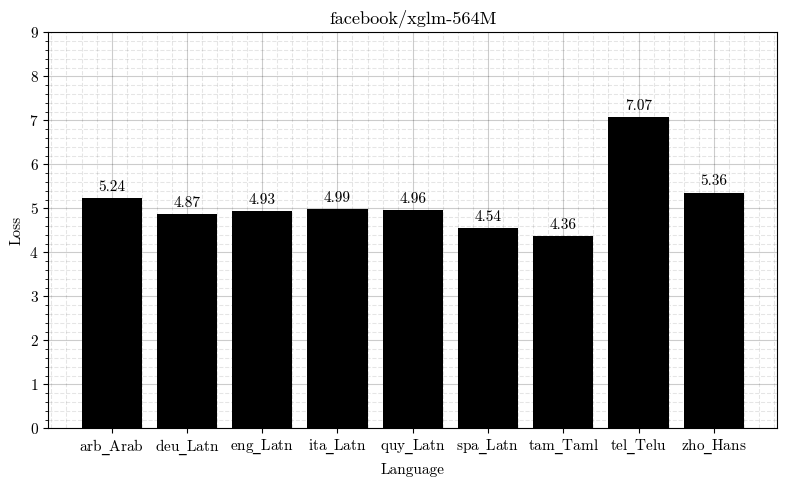

In [17]:
def autolabel(rects: list, ax: plt.Axes) -> plt.Axes:
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect in rects:
        height = rect.get_height()
        ax.annotate(
            "{}".format(round(height, 2)),
            xy=(rect.get_x() + rect.get_width() / 2, height),
            xytext=(0, 3),  # 3 points vertical offset
            textcoords="offset points",
            ha="center",
            va="bottom",
        )
    return ax

# create a figure
fig, axes = plt.subplots(figsize=(8, 5))

# create a bar plot for each language
x = np.arange(len(LANGUAGES))
y = [np.mean(losses[_][SPLIT_TO_PLOT]) for _ in LANGUAGES]

rects = axes.bar(x, y, color="k")
axes = autolabel(rects, axes)

# format plot
axes.set_xlabel("Language")
axes.set_xticks(range(len(LANGUAGES)))
xlabels_for_plot = [label.replace("_", "$\mathrm{\_}$") for label in losses.keys()]
axes.set_xticklabels(xlabels_for_plot) 
axes.set_ylabel("Loss")
axes.set_ylim(0, 9)
axes.set_title(MODEL_NAME)
axes.grid(True, which="major", color="k", linestyle="-", alpha=0.2)
axes.grid(True, which="minor", color="k", linestyle="--", alpha=0.1)
axes.tick_params(axis='x', which='minor', bottom=False) # Disable minor ticks on the x-axis
axes.minorticks_on()
axes.set_axisbelow(True)
fig.tight_layout()
fig.show()

In [18]:
# Free up memory explicitly
del model, inputs, attention_mask, labels, outputs, loss, dataset_per_lang
torch.cuda.empty_cache()

## Comparing XGLM to GPT2

Your next task is to re-run the analysis above, but using `gpt2` as the pre-trained language model. For this exercise, focus on your native language, unless it's English or isn't covered by flores. In that case, pick another language that you can read well.

Compare the language modeling loss of XGLM and GPT2. What do you observe? Investigate the differences in tokenization for XGLM and GPT2. What do you observe? How can the good (or bad) performance of GPT2 be explained?

In [19]:
XGLM_MODEL_NAME = "facebook/xglm-564M"  # XGLM-564M model name
GPT2_MODEL_NAME = "gpt2"  # GPT-2 model name
# LANGS_TO_CHECK = ["spa_Latn"]  # Languages to investigate
LANGS_TO_CHECK = []  # Languages to investigate
SAFE_XGLM_MODEL_NAME = XGLM_MODEL_NAME.replace("facebook/", "")  # Safe string for directories and filenames

# Don't mind the following if-else block, it's just to format the string for the filename
if not LANGS_TO_CHECK:
    STR_LANGS_TO_CHECK = "_"
else:
    STR_LANGS_TO_CHECK = f"_{join_list_elements_with_char(LANGS_TO_CHECK)}_"

# Define both models
model_xglm = load_model(XGLM_MODEL_NAME, verbose=False)
model_gpt2 = load_model(GPT2_MODEL_NAME, verbose=False)

# Define the filenames to save the losses to, so that we don't recalculate them all the time
losses_xglm_filename = (
    f"losses_{SAFE_XGLM_MODEL_NAME}{STR_LANGS_TO_CHECK}bs_{BATCH_SIZE}_pbp_True_ipt_{IGNORE_PADDING_TOKEN_INT}.json"
)
losses_gpt2_filename = (
    f"losses_{GPT2_MODEL_NAME}{STR_LANGS_TO_CHECK}bs_{BATCH_SIZE}_pbp_True_ipt_{IGNORE_PADDING_TOKEN_INT}.json"
)

# Tokenize the dataset for both models
print("Setting up XGLM dataset:\n")
xglm_dataset, xglm_tokenizer = tokenize_dataset(orig_dataset_per_lang, XGLM_MODEL_NAME)
xglm_dataset = batchify_dataset(xglm_dataset, xglm_tokenizer, BATCH_SIZE)
print("\nSetting up GPT-2 dataset:\n")
gpt2_dataset, gpt2_tokenizer = tokenize_dataset(orig_dataset_per_lang, GPT2_MODEL_NAME)
gpt2_dataset = batchify_dataset(gpt2_dataset, gpt2_tokenizer, BATCH_SIZE)
print()

# Load or generate the data, depending on the existence of the previously defined json files
losses_xglm = load_or_generate_data(
    "../cache/losses",
    losses_xglm_filename,
    calculate_losses,
    model_xglm,
    xglm_dataset,
    pad_token_id=xglm_tokenizer.pad_token_id,
    only_for_langs=LANGS_TO_CHECK,
    model_name=XGLM_MODEL_NAME,
)
losses_gpt2 = load_or_generate_data(
    "../cache/losses",
    losses_gpt2_filename,
    calculate_losses,
    model_gpt2,
    gpt2_dataset,
    pad_token_id=gpt2_tokenizer.pad_token_id,
    only_for_langs=LANGS_TO_CHECK,
    model_name=GPT2_MODEL_NAME,
)

Freeing GPU Memory
Free: 3882 MB	Total: 4031 MB
Freeing GPU Memory
Free: 1726 MB	Total: 4031 MB
Setting up XGLM dataset:

Creating dataloaders for eng_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for spa_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for ita_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for deu_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for arb_Arab (dev: 499, devtest: 506 instances)
Creating dataloaders for tel_Telu (dev: 499, devtest: 506 instances)
Creating dataloaders for tam_Taml (dev: 499, devtest: 506 instances)
Creating dataloaders for quy_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for zho_Hans (dev: 499, devtest: 506 instances)

Setting up GPT-2 dataset:

Creating dataloaders for eng_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for spa_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders for ita_Latn (dev: 499, devtest: 506 instances)
Creating dataloaders f

/tmp/ipykernel_15725/4025056491.py:34: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


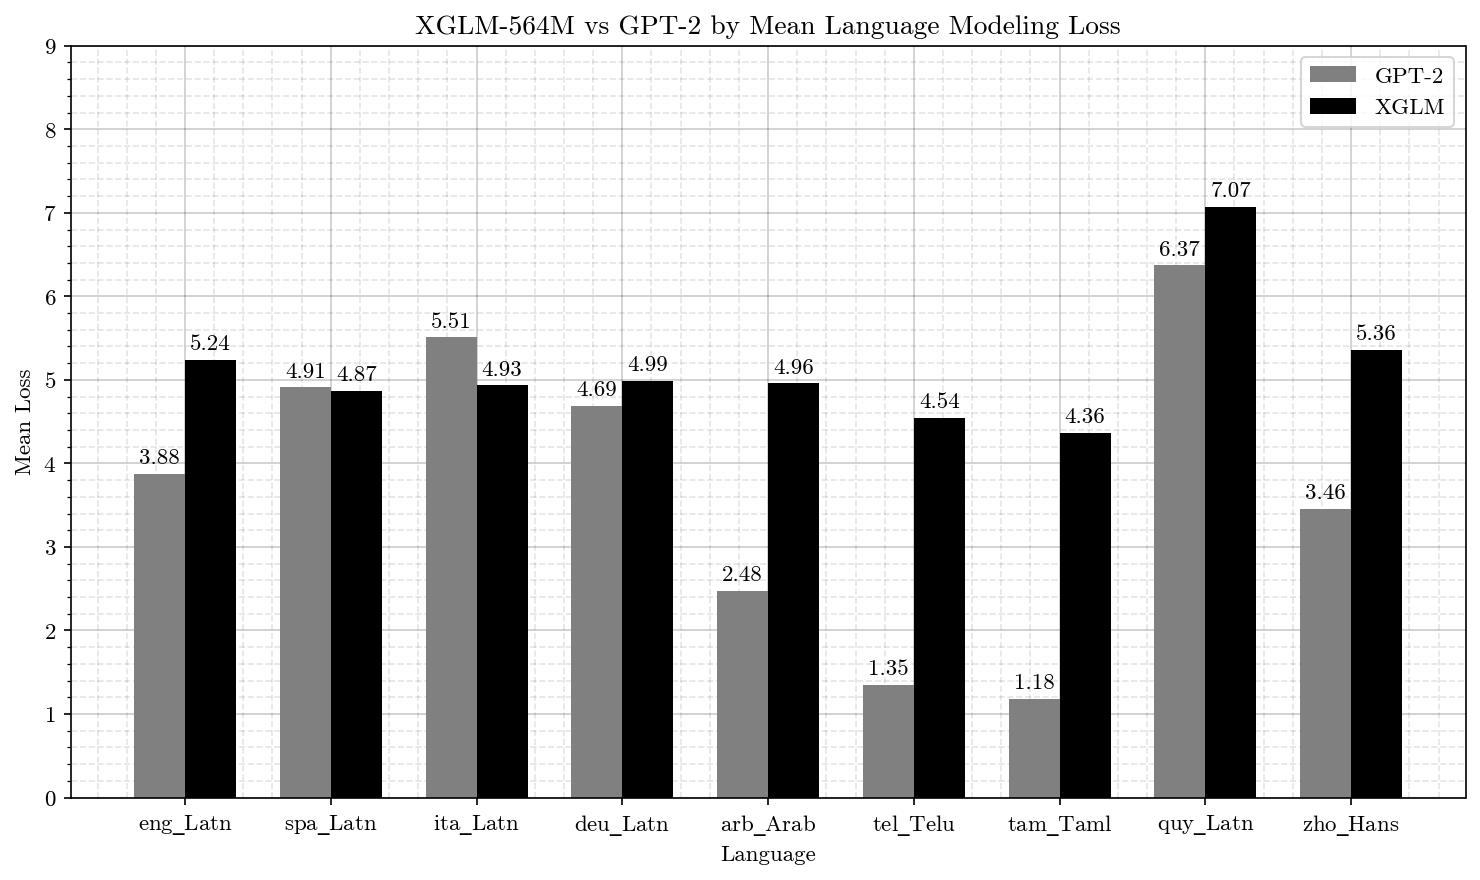

In [20]:
matplotlib.rcParams["figure.dpi"] = 150

LANGS_TO_CHECK = LANGUAGES
split_to_plot = "devtest"

# Prepare data for plotting
labels = [lang.replace("_", "$\mathrm{\_}$") for lang in LANGS_TO_CHECK]
finetuned_losses = [np.mean(losses_gpt2[language][split_to_plot]) for language in LANGS_TO_CHECK]
xglm_losses = [np.mean(losses_xglm[language][split_to_plot]) for language in LANGS_TO_CHECK]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width / 2, finetuned_losses, width, label="GPT-2", color="gray")
rects2 = ax.bar(x + width / 2, xglm_losses, width, label="XGLM", color="black")

# format plot
ax.set_title("XGLM-564M vs GPT-2 by Mean Language Modeling Loss")
ax.set_ylabel("Mean Loss")
ax.set_xlabel("Language") 
ax.set_xticks(x)
ax.set_xticklabels(labels, ha="center")
ax.set_ylim(0, 9)
ax.legend()
ax = autolabel(rects1, ax)
ax = autolabel(rects2, ax)
ax.grid(True, which="major", color="k", linestyle="-", alpha=0.2)
ax.grid(True, which="minor", color="k", linestyle="--", alpha=0.1)
ax.tick_params(axis='x', which='minor', bottom=False) # Disable minor ticks on the x-axis
ax.minorticks_on()
ax.set_axisbelow(True)
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(LOCAL_CACHE, "plots_task1", "xglm_vs_gpt2_mean_losses.jpg"), dpi=300, bbox_inches='tight')

/tmp/ipykernel_15725/2809910018.py:40: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


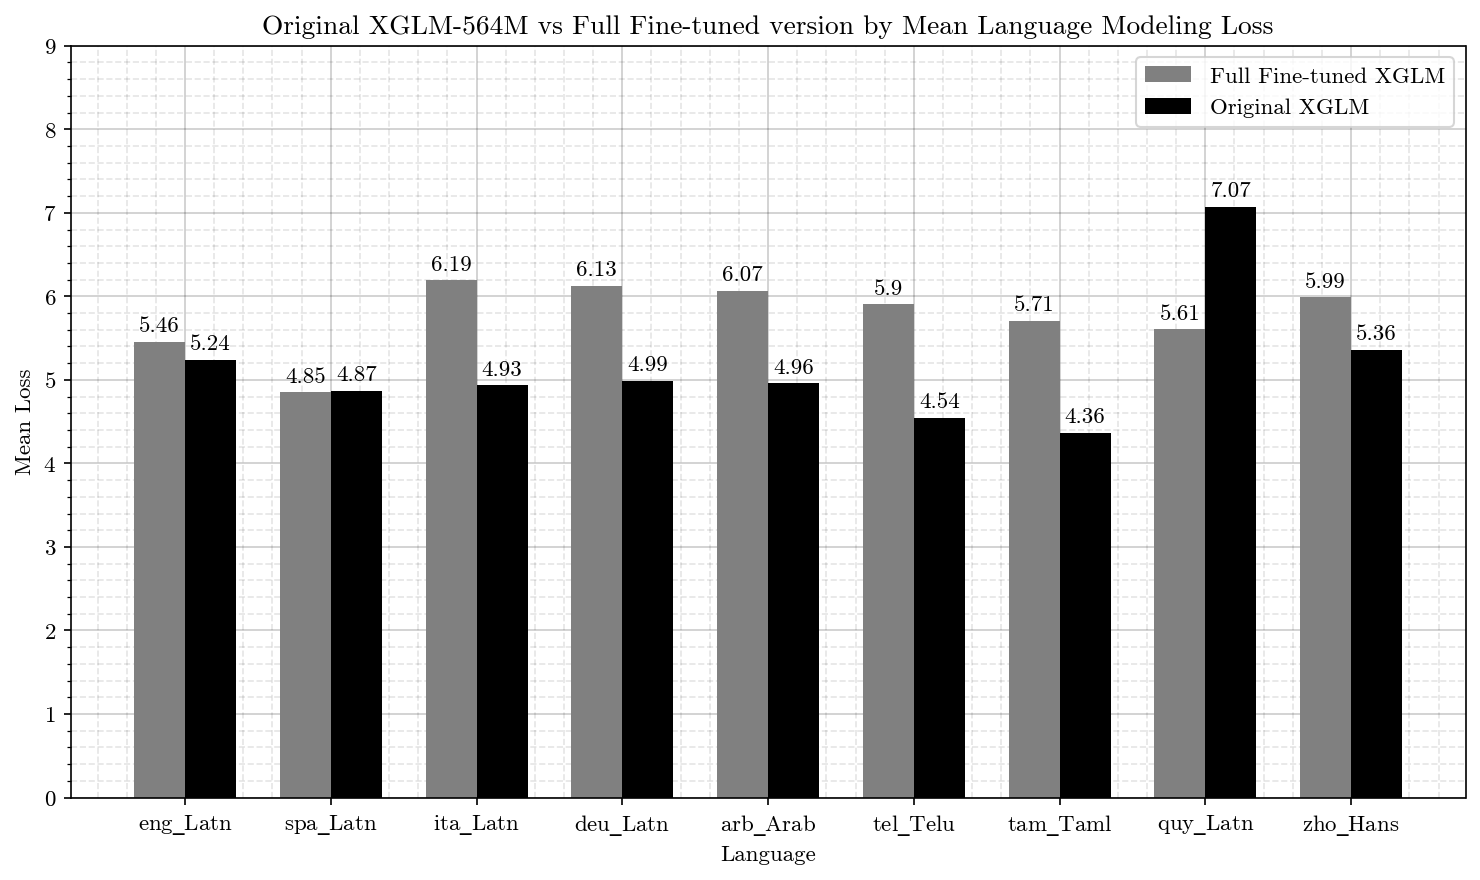

In [21]:
losses_xglm_filename = "losses_xglm-564M_bs_2_pbp_True_ipt_-100.json"
losses_xglm_finetuned = "losses_full-fine-tuned-xglm.json"

losses_xglm = load_json_from("../cache/losses", losses_xglm_filename)
losses_xglm_finetuned = load_json_from("../cache/losses", losses_xglm_finetuned)

matplotlib.rcParams["figure.dpi"] = 150

LANGS_TO_CHECK = LANGUAGES
split_to_plot = "devtest"

# Prepare data for plotting
labels = [lang.replace("_", "$\mathrm{\_}$") for lang in LANGS_TO_CHECK]
finetuned_losses = [np.mean(losses_xglm_finetuned[language][split_to_plot]) for language in losses_xglm_finetuned]
xglm_losses = [np.mean(losses_xglm[language][split_to_plot]) for language in losses_xglm_finetuned]

x = np.arange(len(labels))  # the label locations
width = 0.35  # the width of the bars

fig, ax = plt.subplots(figsize=(10, 6))
rects1 = ax.bar(x - width / 2, finetuned_losses, width, label="Full Fine-tuned XGLM", color="gray")
rects2 = ax.bar(x + width / 2, xglm_losses, width, label="Original XGLM", color="black")

# format plot
ax.set_title("Original XGLM-564M vs Full Fine-tuned version by Mean Language Modeling Loss")
ax.set_ylabel("Mean Loss")
ax.set_xlabel("Language") 
ax.set_xticks(x)
ax.set_xticklabels(labels, ha="center")
ax.set_ylim(0, 9)
ax.legend()
ax = autolabel(rects1, ax)
ax = autolabel(rects2, ax)
ax.grid(True, which="major", color="k", linestyle="-", alpha=0.2)
ax.grid(True, which="minor", color="k", linestyle="--", alpha=0.1)
ax.tick_params(axis='x', which='minor', bottom=False) # Disable minor ticks on the x-axis
ax.minorticks_on()
ax.set_axisbelow(True)
fig.tight_layout()
fig.show()
fig.savefig(os.path.join(LOCAL_CACHE, "plots_task1", "xglm_vs_finetuned.jpg"), dpi=300, bbox_inches='tight')